## Biophysical branching model

In this notebook, we leverage Jax in order to perform GPU accelerated simulation of branching model by simulating nutrient diffusion and density-dependent diffusion of cell dispersal.


In [ ]:
%reset -f
# Import numerical jax dependencies
import jax
from jax import numpy as jnp
from jax import vmap

# For readability. 
from collections import namedtuple

# Import plotting dependencies
import matplotlib.pyplot as plt
from jax_tqdm import scan_tqdm
from IPython.display import clear_output
import time


##### PDE Update Function with Diffusion for Both 𝑁 and 𝐶
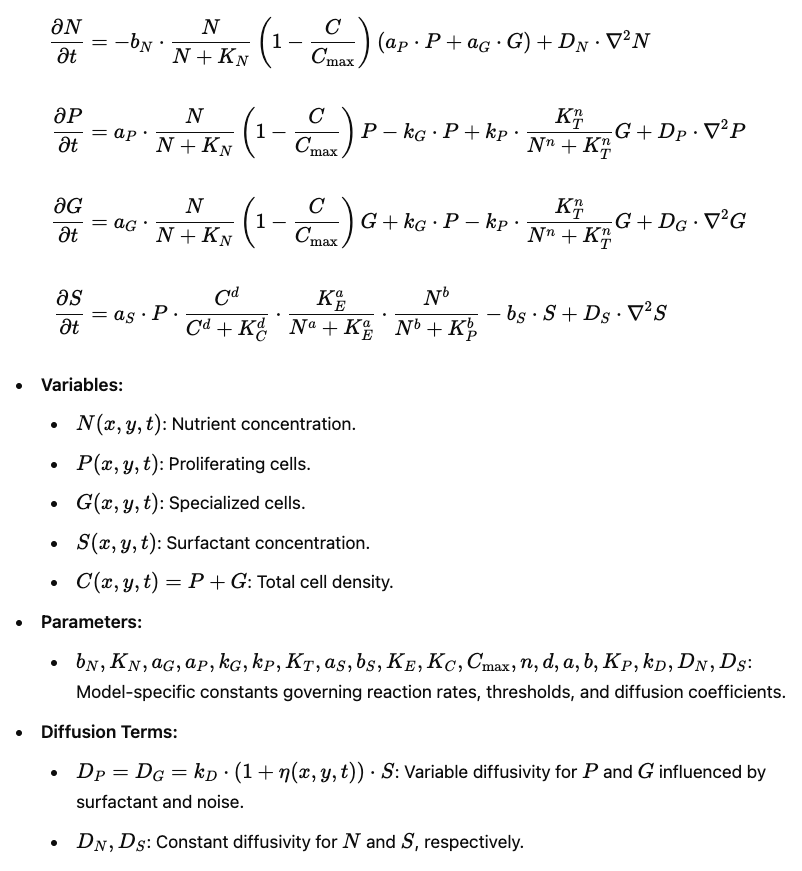

In [ ]:
import jax
import jax.numpy as jnp
from jax import jit
import matplotlib.pyplot as plt
import os
import numpy as np

def initialize_fields(nx, ny, Lx, Ly, N0, C0, R0):
    """
    Initializes the fields N, P, G, S.
    
    Parameters:
    - nx, ny: Grid dimensions.
    - Lx, Ly: Physical domain sizes.
    - N0: Initial nutrient concentration.
    - C0: Initial cell concentration at the center.
    - R0: Radius for initial cell concentration.
    
    Returns:
    - Tuple of (N_initial, P_initial, G_initial, S_initial)
    """
    x = jnp.linspace(0, Lx, nx, endpoint=False)
    y = jnp.linspace(0, Ly, ny, endpoint=False)
    X, Y = jnp.meshgrid(x, y, indexing='ij')
    
    # Initialize Nutrient N uniformly
    N_initial = jnp.full((nx, ny), N0)
    
    # Initialize P and G
    P_initial = jnp.zeros((nx, ny))
    G_initial = C0 * jnp.exp(-((X - Lx/2)**2 + (Y - Ly/2)**2))
 
     
    # Initialize S as zero
    S_initial = jnp.zeros((nx, ny))
    
    return N_initial, P_initial, G_initial, S_initial

@jit
def laplacian(u, dx, dy):
    """
    Computes the Laplacian of a 2D field using central differences.
    
    Parameters:
    - u: 2D array.
    - dx, dy: Spatial step sizes.
    
    Returns:
    - Laplacian of u.
    """
    return (
        (jnp.roll(u, 1, axis=0) - 2 * u + jnp.roll(u, -1, axis=0)) / dx**2 +
        (jnp.roll(u, 1, axis=1) - 2 * u + jnp.roll(u, -1, axis=1)) / dy**2
    )



In [ ]:
@jit
def pde_update_fdm(pde_state, pde_params, dx, dy, dt, noise):
    N, P, G, S = pde_state
    (DN, DS, kD, bN, aG, aP, kG, kP, KN, KT, aS, bS, KE, KC, Cmax, n, d, a, b, KP) = pde_params
    
    C = P + G
    
    fG = (N / (N + KN)) * (1 - C / Cmax)
    dN = -bN * fG * (aP * P + aG * G)
    fT = (KT ** n) / (N ** n + KT ** n)
    dP = aP * fG * P - kG * P + kP * fT * G
    dG = aG * fG * G + kG * P - kP * fT * G
    fQS = (C ** d) / (C ** d + KC ** d)
    fE = (KE ** a) / (N ** a + KE ** a)
    fP = (N ** b) / (N ** b + KP ** b)
    f = fQS * fE * fP
    dS = aS * P * f - bS * S
    
    laplacian_N = laplacian(N, dx, dy)
    laplacian_S = laplacian(S, dx, dy)
    D_P = kD * (1 + noise) * S
    D_P = jnp.clip(D_P, 0, None)
    D_G = kD * (1 + noise) * S
    D_G = jnp.clip(D_G, 0, None)
    laplacian_P = laplacian(P, dx, dy)
    laplacian_G = laplacian(G, dx, dy)
    
    N_new = N + dt * (dN + DN * laplacian_N)
    P_new = P + dt * (dP + D_P * laplacian_P)
    G_new = G + dt * (dG + D_G * laplacian_G)
    S_new = S + dt * (dS + DS * laplacian_S)
    
    N_new = jnp.clip(N_new, 0, None)
    P_new = jnp.clip(P_new, 0, None)
    G_new = jnp.clip(G_new, 0, None)
    S_new = jnp.clip(S_new, 0, None)
    
    return (N_new, P_new, G_new, S_new), None


In [7]:
2.06/0.64

3.21875

[41.08, 5.79, 2580.0, 15, 24.24, 8.67, 75.36, 16.98, 0.64, 6.45, 1.0, 170.52, 6.08, 4.55, 91.06, 2, 2.205, 1.69, 1.84, 2.06, 31.5, 1.59]


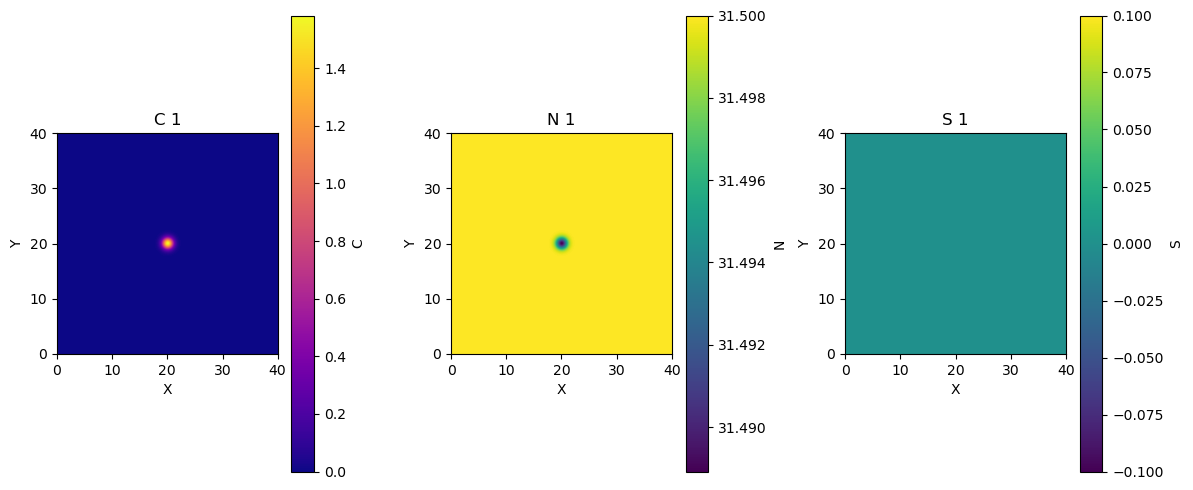

Step 0: Time = 0.0000, Colony Radius = 2.2455


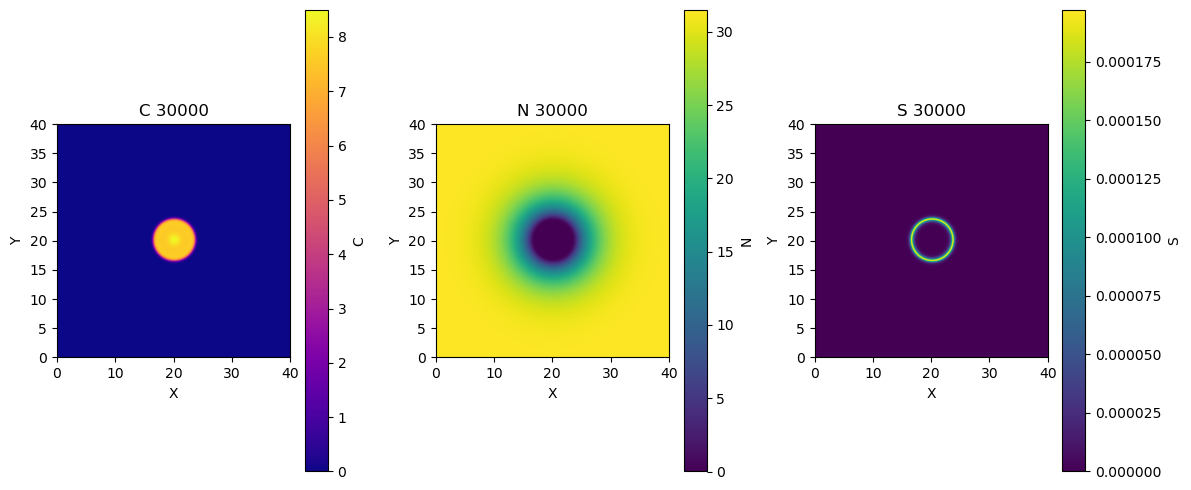

Step 29999: Time = 0.6000, Colony Radius = 4.3404


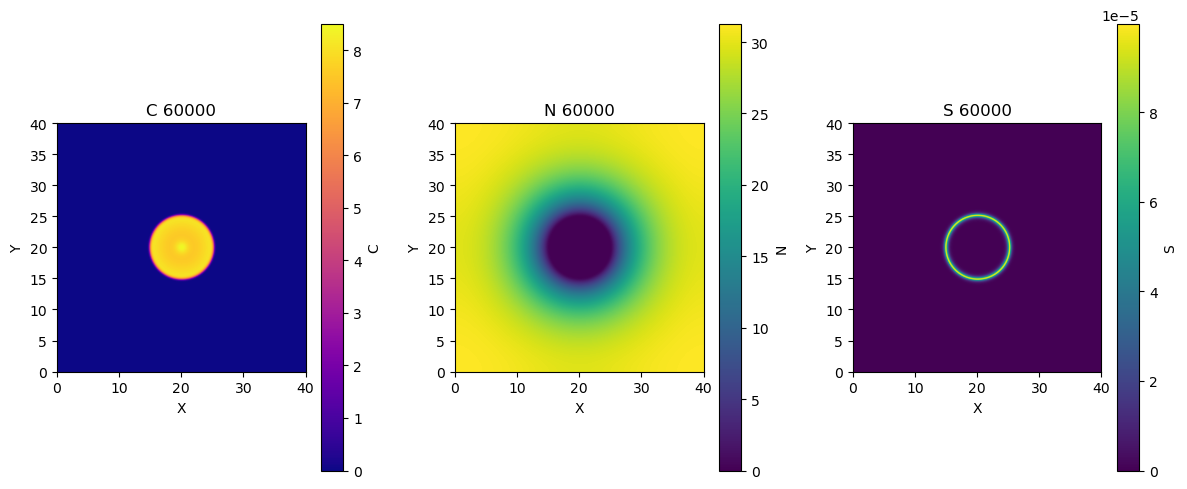

Step 59999: Time = 1.2000, Colony Radius = 5.6749


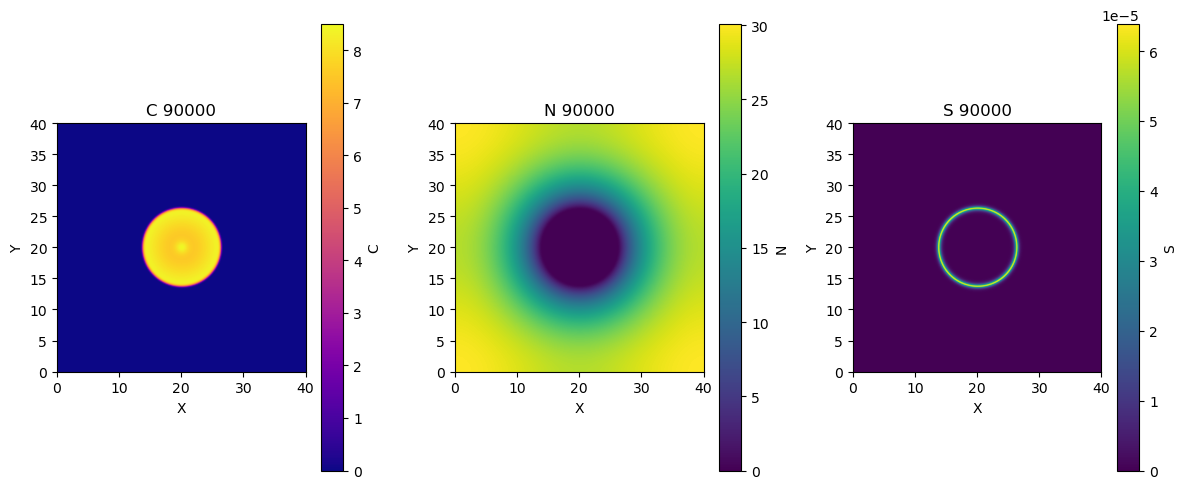

Step 89999: Time = 1.8000, Colony Radius = 6.7346


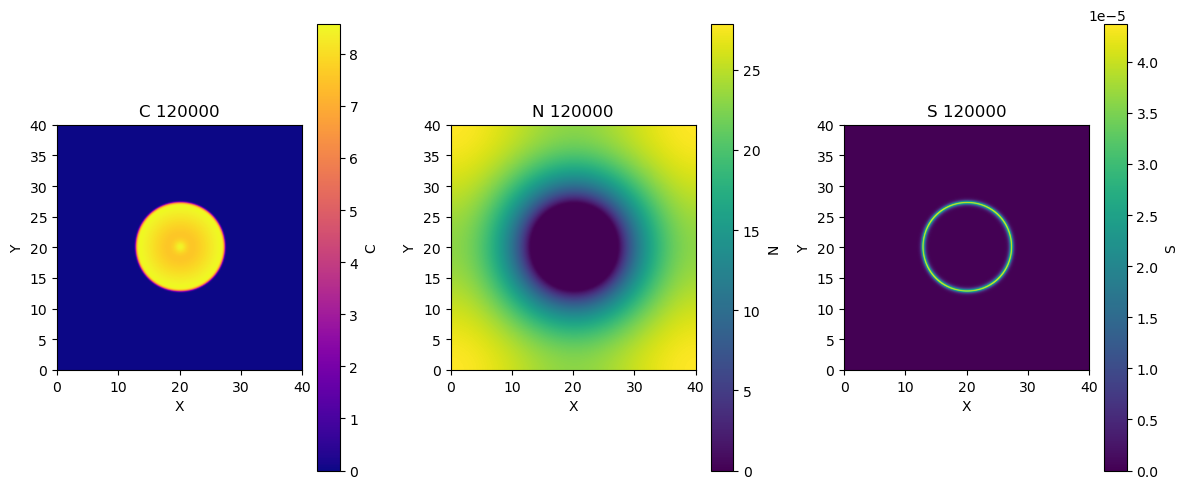

Step 119999: Time = 2.4000, Colony Radius = 7.6369


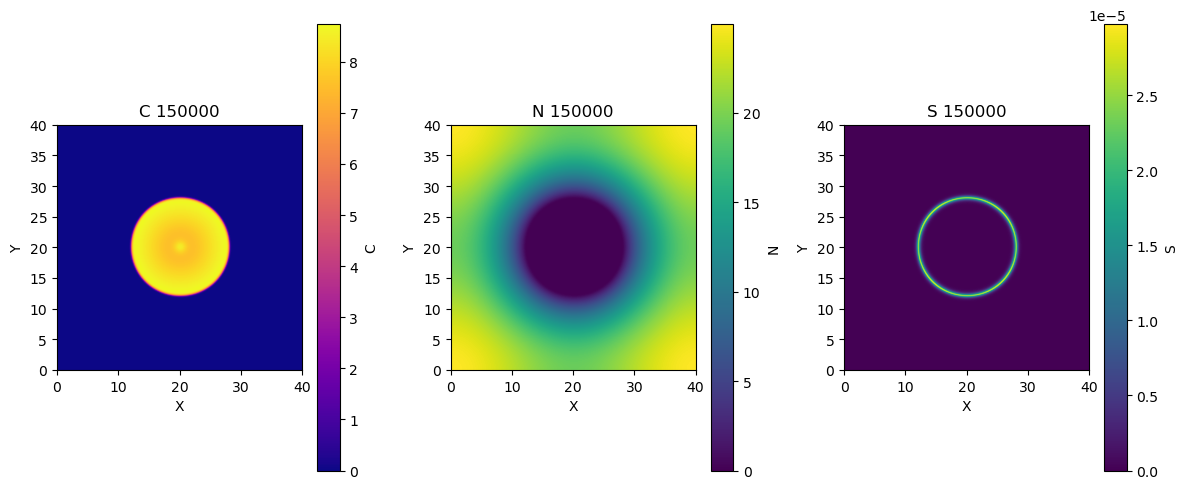

Step 149999: Time = 3.0000, Colony Radius = 8.4154


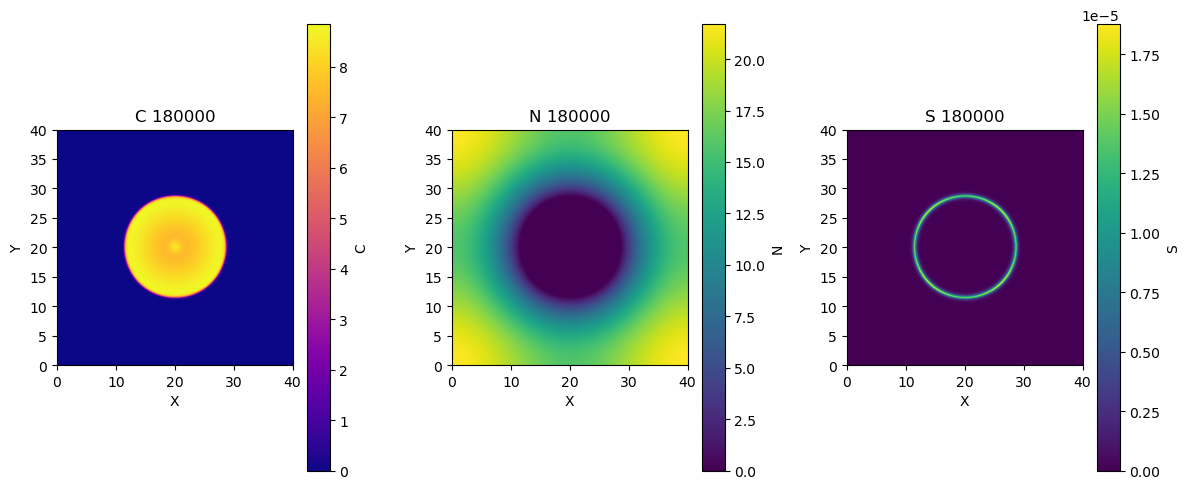

Step 179999: Time = 3.6000, Colony Radius = 9.1185


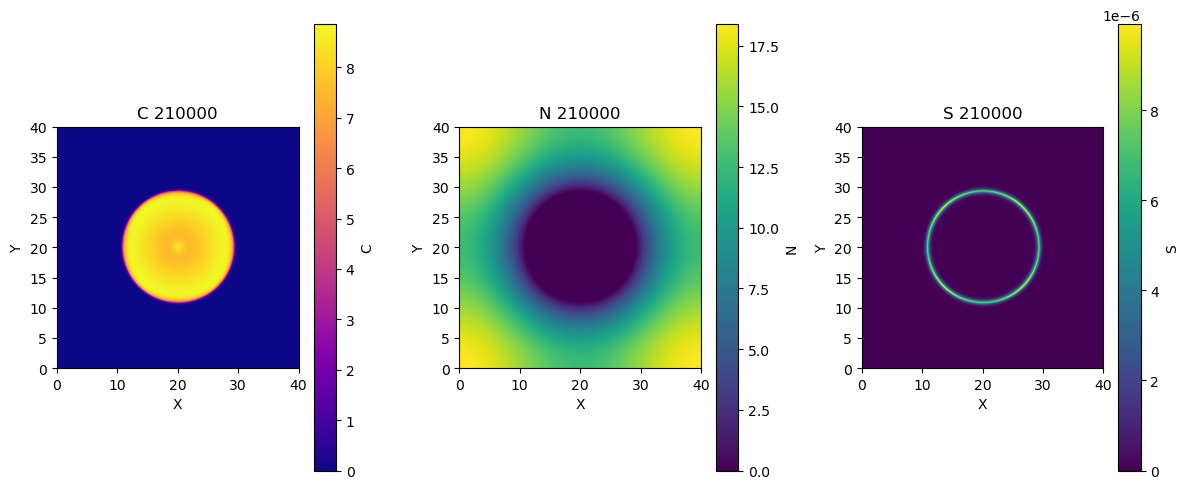

Step 209999: Time = 4.2000, Colony Radius = 9.7717


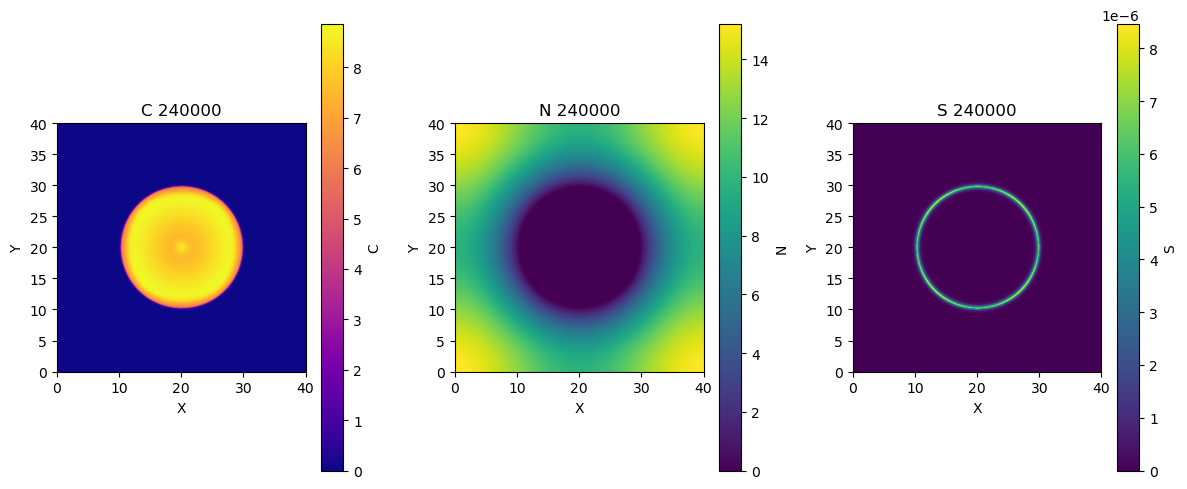

Step 239999: Time = 4.8000, Colony Radius = 10.0900


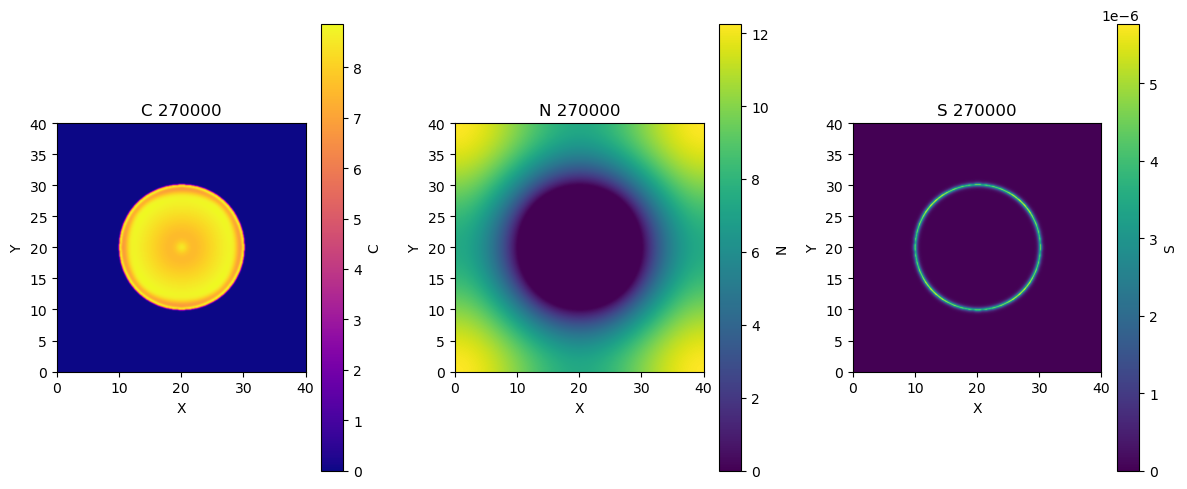

Step 269999: Time = 5.4000, Colony Radius = 10.3770


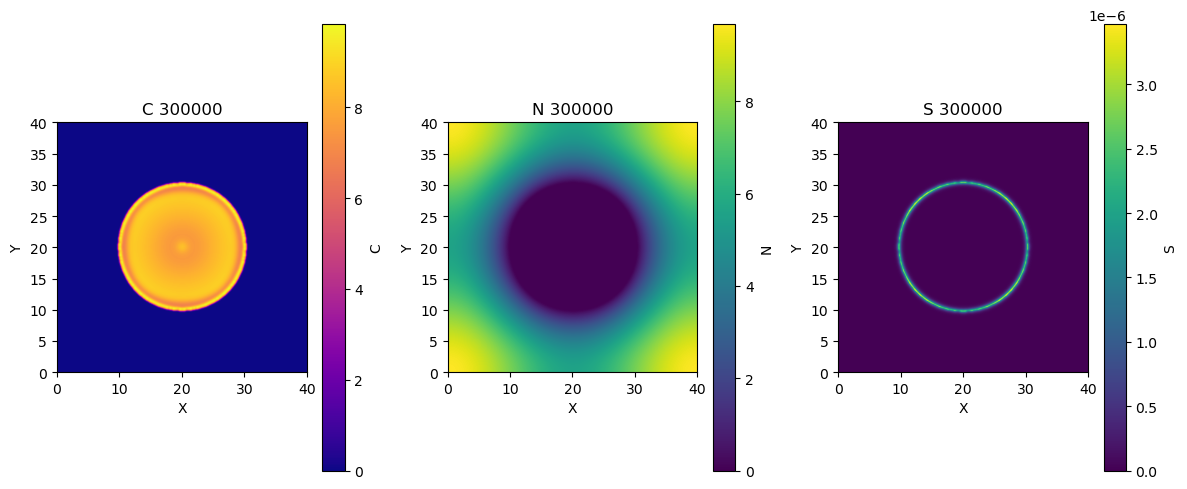

Step 299999: Time = 6.0000, Colony Radius = 10.5929


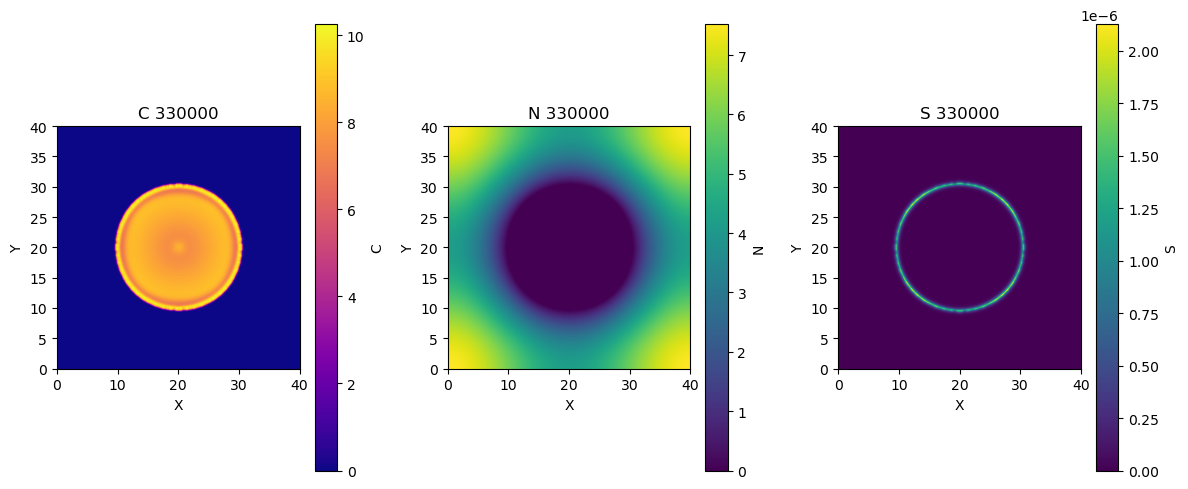

Step 329999: Time = 6.6000, Colony Radius = 10.7631


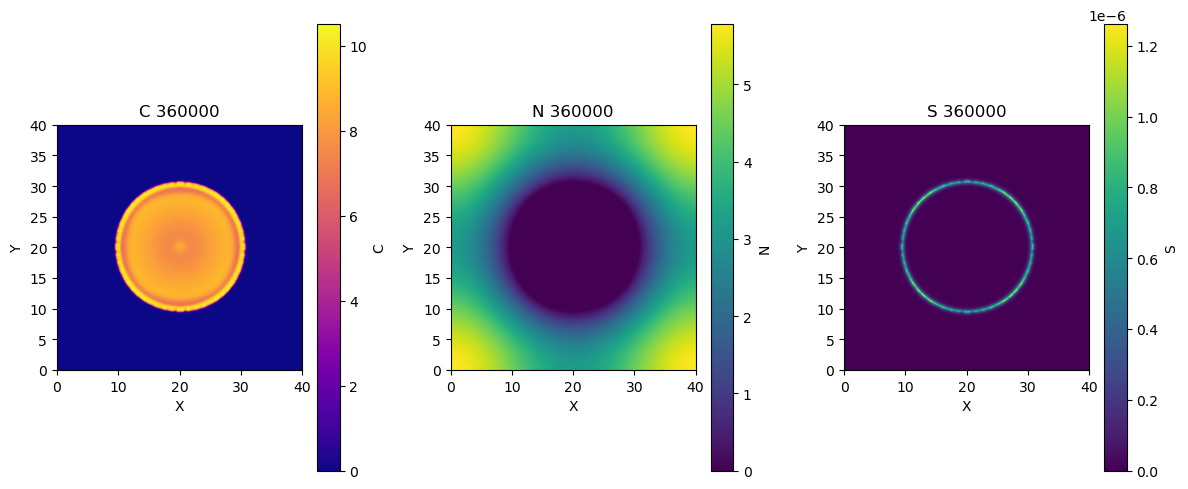

Step 359999: Time = 7.2000, Colony Radius = 10.8889


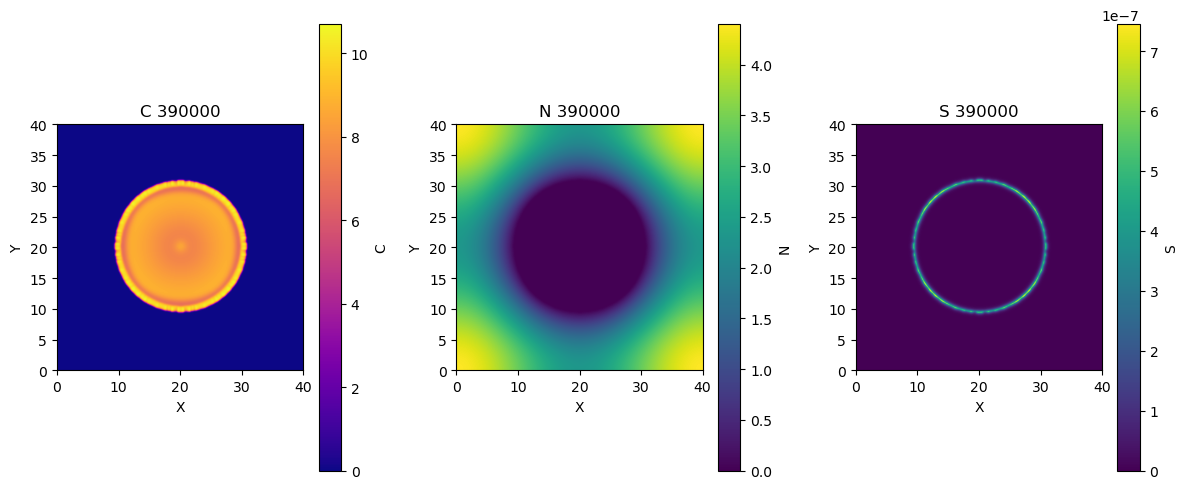

Step 389999: Time = 7.8000, Colony Radius = 10.9868


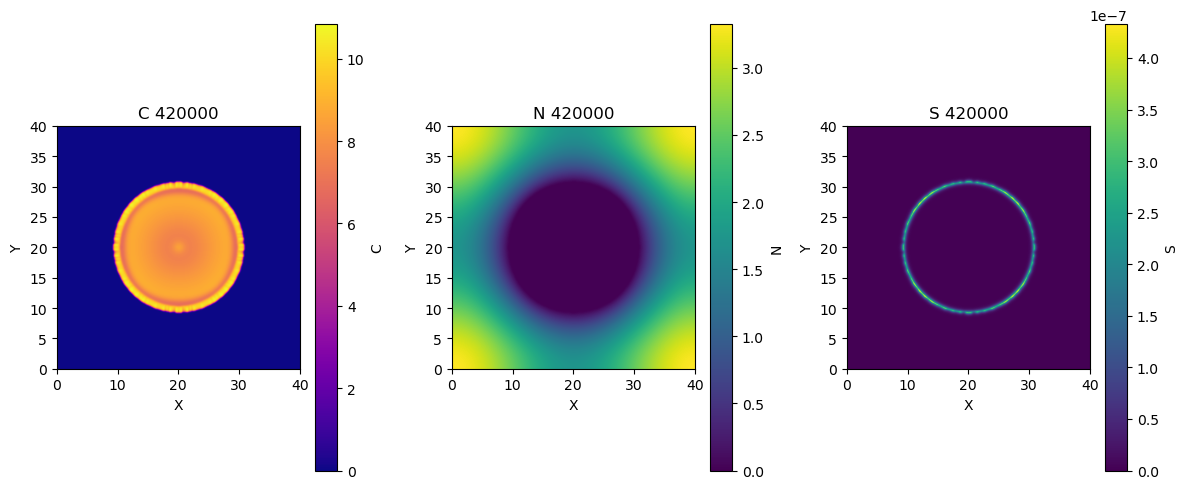

Step 419999: Time = 8.4000, Colony Radius = 11.0621


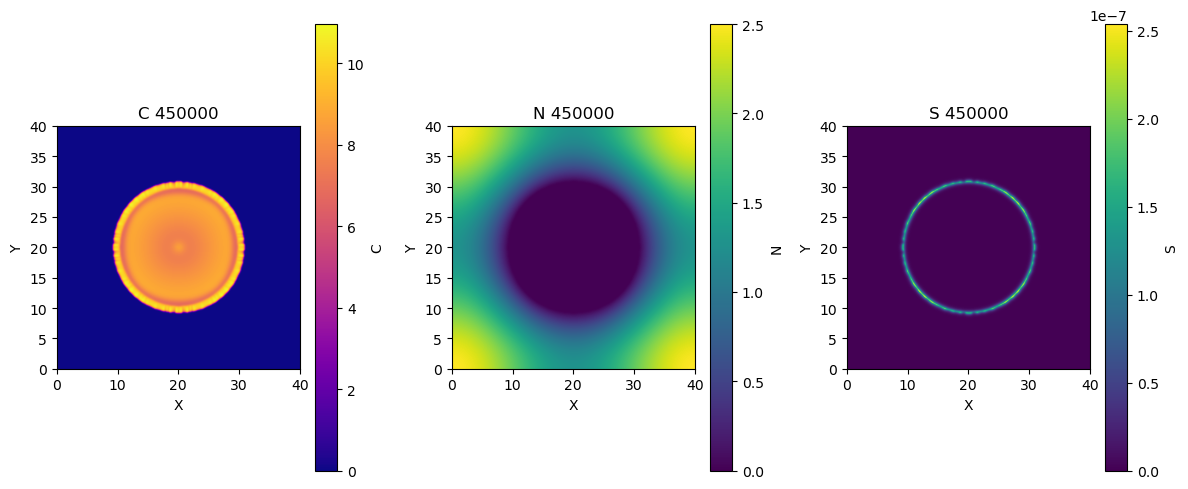

Step 449999: Time = 9.0000, Colony Radius = 11.1165


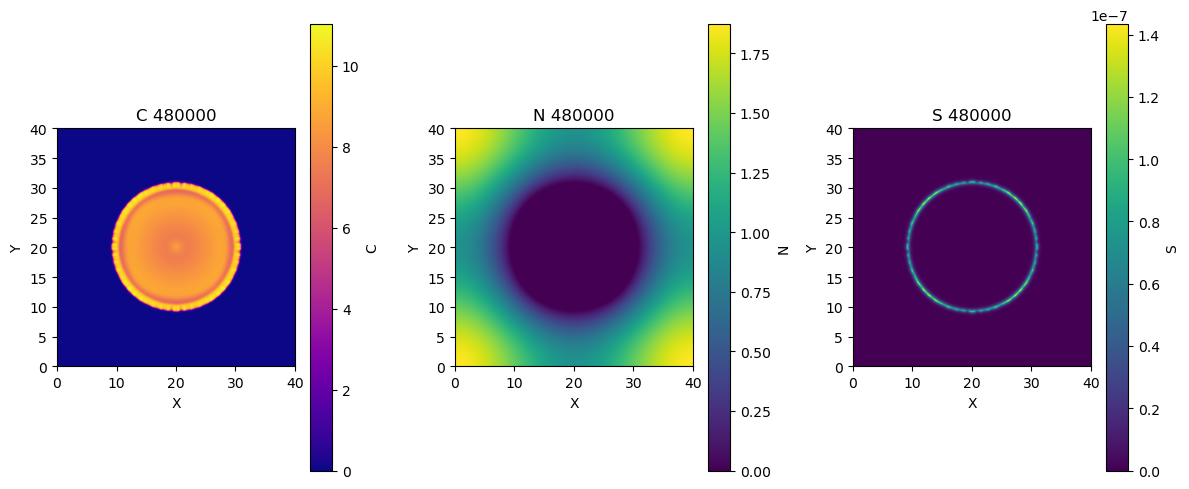

Step 479999: Time = 9.6000, Colony Radius = 11.1601


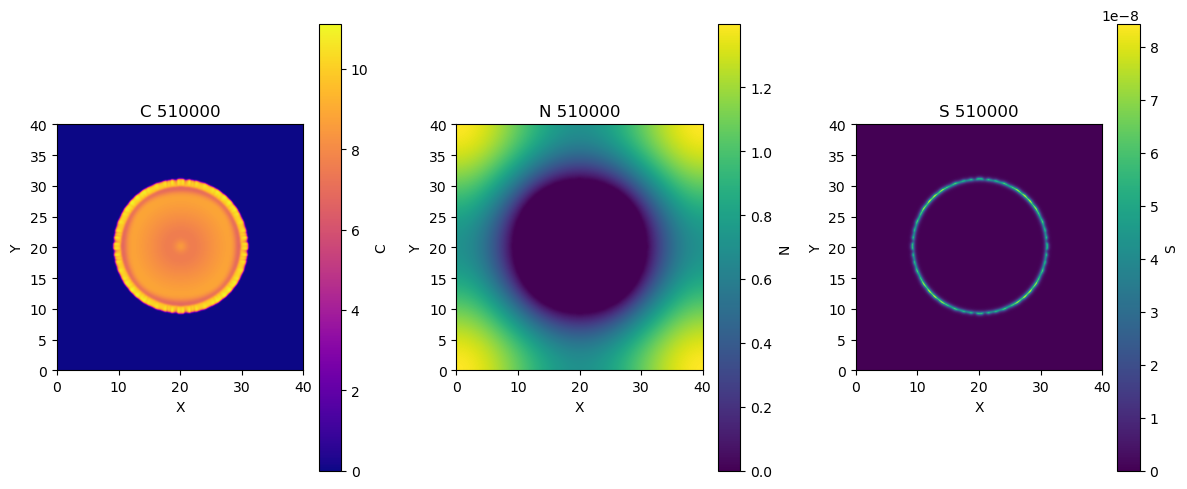

Step 509999: Time = 10.2000, Colony Radius = 11.1851


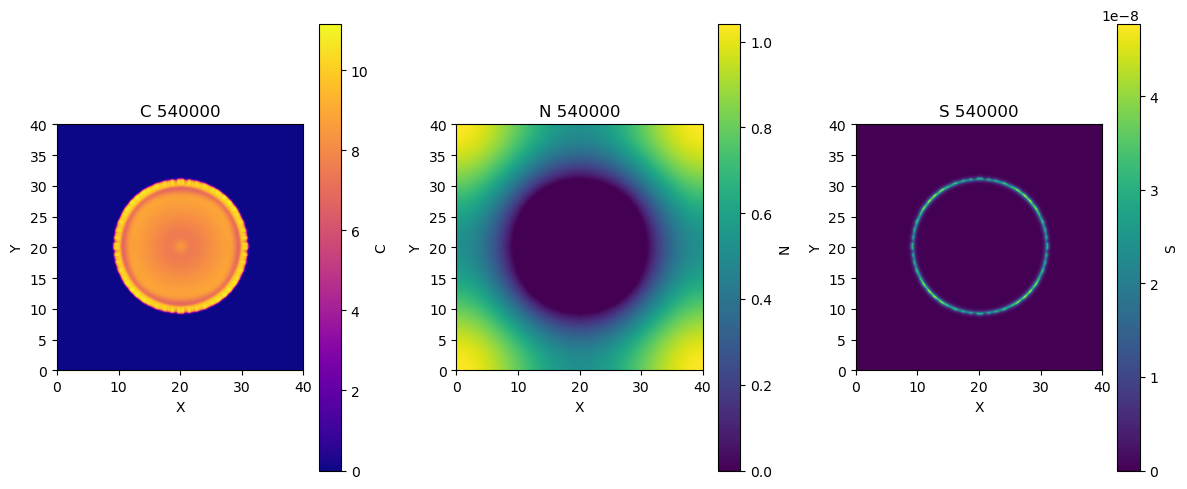

Step 539999: Time = 10.8000, Colony Radius = 11.2139


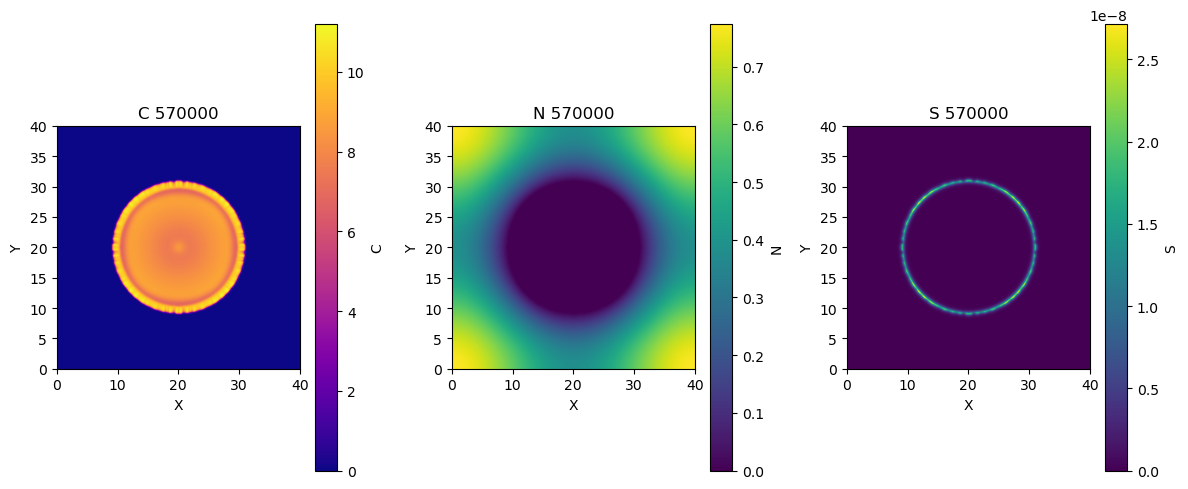

Step 569999: Time = 11.4000, Colony Radius = 11.2323


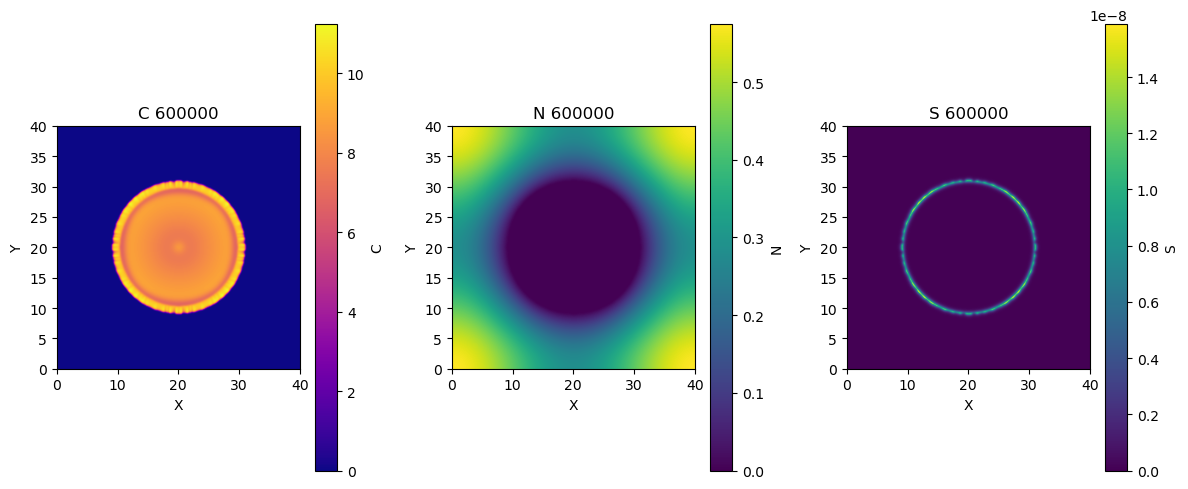

Step 599999: Time = 12.0000, Colony Radius = 11.2500
Simulation completed.


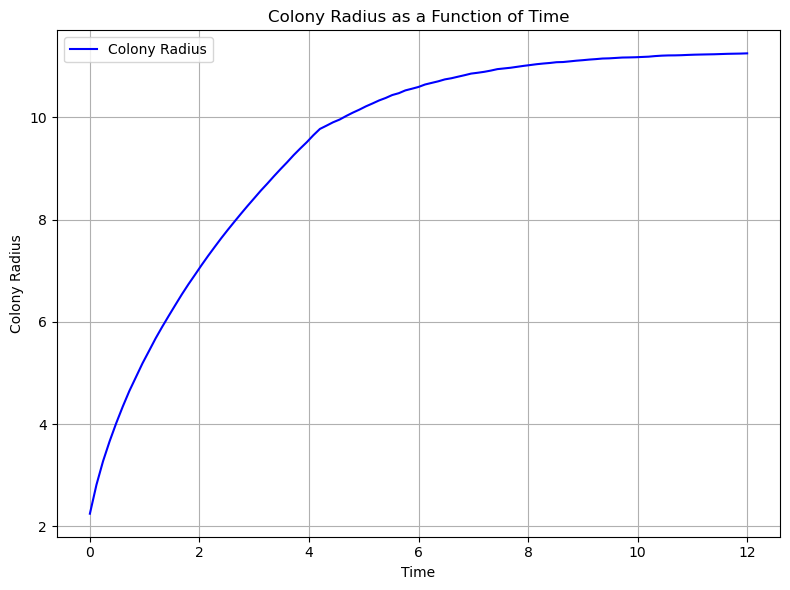

Simulation took 604.29 seconds


In [66]:
import time

#parameters to generate branching
# L = 80
# base parameters (from Nan)
# with modifications aS = 5. 

def run_simulation_fdm():
    """
    Runs the PDE simulation for nutrient concentration (N), proliferating cells (P),
    specialized cells (G), and surfactant (S), using finite difference methods.
    Injects noise into the effective diffusivity D_eff.
    Computes colony area by thresholding C > 0.01 and plots colony radius as a function of time.
    """
    # Define grid parameters
    nx, ny = 401, 401  # Number of grid points (matches MATLAB's nx=401)
    Lx, Ly = 40, 40  # Physical domain size, matching MATLAB's L=20
    dx = Lx / nx
    dy = Ly / ny

    # Define total simulation time and steps
    dt = 2e-5  
    nt = 600000  # Number of time steps
    frames = 20
    samples = 100

    # Define PDE parameters
    # Parameters = [DN, DS, kD, bN, aG, aP, kG, kP, KN, KT, aS, bS, KE, KC, Cmax, n, d, a, b, KP, delta, N0, C0]
    # For demonstration, define Parameters directly as per MATLAB code
    Parameters = [
        41.08,    # DN = 41.08
        5.79,    # DS = 5.79
        2.58e3,    # kD 2.58e3
        15,    # bN
        24.24,    # aG
        8.67,    # aP
        75.36,    # kG
        16.98,    # kP
        0.64,   # KN
        6.45,    # KT
        1.0,    # aS = 1.0
        170.52,    # bS = 170.52
        6.08,    # KE
        4.55,    # KC
        91.06,    # Cmax
        2,    # n_param
        2.205,    # d_param
        1.69,    # a_param
        1.84,    # b_param
        2.06,    # KP
       31.5,    # N0
        1.59     # C0
    ]

    # Extract parameters
    DN, DS, kD, bN, aG, aP, kG, kP, KN, KT, aS, bS, KE, KC, Cmax, n, d, a, b, KP, N0, C0 = Parameters

    print(Parameters)
    # Update pde_params tuple
    pde_params = (DN, DS, kD, bN, aG, aP, kG, kP, KN, KT, aS, bS, KE, KC, Cmax, n, d, a, b, KP)

    # Define initial conditions
    R0 = 1.0    # Radius for initial cell concentration, matching MATLAB's exp(- (rr/1)^2 )

    N_initial, P_initial, G_initial, S_initial = initialize_fields(nx, ny, Lx, Ly, N0, C0, R0)
    pde_state = (N_initial, P_initial, G_initial, S_initial)

    # Define noise parameters
    epsilon = 0.2 # Noise amplitude; adjust as needed

    # Initialize PRNG key
    seed = 42  # Arbitrary seed for reproducibility
    key = jax.random.PRNGKey(seed)

    # Initialize lists to store colony radius and time
    colony_radius_list = []
    time_list = []

    # Define threshold for colony
    C_threshold = 0.01

    # Compute cell area
    cell_area = dx * dy

    # Create directory to save outputs (optional)
    save_dir = 'simulation_outputs_fdm'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

#    plt.figure(figsize=(12, 5))
    # Simulation loop
    for step in range(nt):
        # Generate a new random key for this step
        key, subkey = jax.random.split(key)

        # Generate noise: Gaussian noise with mean 0 and standard deviation epsilon
        noise = epsilon * (jax.random.uniform(subkey, shape=(nx, ny)) * 2 - 1)

        # Update PDE state with noise injected into D_eff using FDM
        pde_state, _ = pde_update_fdm(
            pde_state,
            pde_params,
            dx,
            dy,
            dt,
            noise
        )

    
        # Extract updated N, P, G, S
        N, P, G, S = pde_state

        # Compute total cell density C = P + G
        C = P + G

        if (step == 0) or ((step + 1) % (nt//samples) == 0):
            # Compute colony area by thresholding C > C_threshold
            colony_mask = C > C_threshold
            colony_area = jnp.sum(colony_mask) * cell_area

            # Compute colony radius assuming circular colony
            colony_radius = jnp.sqrt(colony_area / jnp.pi)
            colony_radius_list.append(colony_radius)
            time_list.append(step * dt)

        # Optional: Visualization and data saving every 500 steps
        if (step == 0) or ((step+1) % (nt//frames) == 0):
            plt.figure(figsize=(12, 5))

            # Plot C (Total Cell Density)
            plt.subplot(1, 3, 1)
            plt.imshow(C, extent=(0, Lx, 0, Ly), origin='lower', cmap='plasma')
            plt.colorbar(label='C')
            plt.title(f'C {step + 1}')
            plt.xlabel('X')
            plt.ylabel('Y')

            # Plot N (Nutrient Concentration)
            plt.subplot(1, 3, 2)
            plt.imshow(N, extent=(0, Lx, 0, Ly), origin='lower', cmap='viridis')
            plt.colorbar(label='N')
            plt.title(f'N {step + 1}')
            plt.xlabel('X')
            plt.ylabel('Y')

            # Plot N (Nutrient Concentration)
            plt.subplot(1, 3, 3)
            plt.imshow(S, extent=(0, Lx, 0, Ly), origin='lower', cmap='viridis')
            plt.colorbar(label='S')
            plt.title(f'S {step + 1}')
            plt.xlabel('X')
            plt.ylabel('Y')

            plt.tight_layout()
            plt.show()
            # Optionally, save the plots
            # plt.savefig(os.path.join(save_dir, f'step_{step}.png'))
            # plt.close()

            # Print progress and colony radius
            print(f"Step {step}: Time = {step*dt:.4f}, Colony Radius = {colony_radius:.4f}")

    print("Simulation completed.")

    # Convert lists to NumPy arrays for plotting
    colony_radius_array = jnp.array(colony_radius_list)
    time_array = jnp.array(time_list)

    # Plot Colony Radius vs Time
    plt.figure(figsize=(8, 6))
    plt.plot(time_array, colony_radius_array, label='Colony Radius', color='blue')
    plt.xlabel('Time')
    plt.ylabel('Colony Radius')
    plt.title('Colony Radius as a Function of Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # Optionally, save the plot
    # plt.savefig(os.path.join(save_dir, 'colony_radius_vs_time_fdm.png'))



start = time.time()
run_simulation_fdm()
end = time.time()
print(f"Simulation took {end - start:.2f} seconds")
